 # Data Loader

In [40]:
# Read tiff
from tifffile import TiffFile
import numpy as np

class TiffReader:
    def __init__(self, filename):
        self.filename = filename
        self.tiff_file = TiffFile(filename)

    def read_image(self, index=0):
        """Read an image from the TIFF file at the specified index."""
        if index < 0 or index >= len(self.tiff_file.pages):
            raise IndexError("Index out of range for TIFF pages.")
        return self.tiff_file.pages[index].asarray()
    
    def len(self):
        """Return the number of images in the TIFF file."""
        return len(self.tiff_file.pages)

    def close(self):
        """Close the TIFF file."""
        self.tiff_file.close()
        

In [41]:
# Read png
import cv2

class PngReader:
    def __init__(self, path):
        self.path = path

    def read_image(self, index=0):
        """Read a PNG image from the specified path."""

        file_name = f"{self.path}/depth{index:05d}.png"

        return cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
    
    def len(self):
        """Return the number of images in the PNG sequence."""
        # Assuming the PNG files are named in a sequential manner
        import os
        files = [f for f in os.listdir(self.path) if f.startswith('depth') and f.endswith('.png')]
        return len(files)
    
    def close(self):
        """Close the PNG reader."""
        # No specific close operation needed for PNG files
        pass


 # Motion Artifact Removal

In [42]:
import cupy as cp
import cv2

class MotionArtifactRemover:
    def __init__(self, window_size=5, batch_size=1, alpha=3, fps=30):
        """
        Initialize the MotionArtifactRemover with parameters for window size, batch size, alpha, and fps.
        """
        self.window_frames = window_size * fps
        self.batch_frames = batch_size * fps
        self.alpha = alpha
        self.frames = []
        self.frame_number = 0
        self.poped_frames = 0

    def process_frame(self, frame):
        """
        Process a single frame to remove motion artifacts.
        """
        frame = cp.array(frame)  # Move frame to GPU

        self.frames.append(frame)
        self.frame_number += 1

        # Maintain a sliding window of frames
        if len(self.frames) > self.window_frames:
            self.frames.pop(0)
            self.poped_frames += 1

        H, W = frame.shape
        MA = cp.zeros((H, W))  # Store averaged depth images
        F = cp.ones((H, W))  # Store validity flags

        # Template matching
        template_index = int(self.batch_frames * cp.floor((self.frame_number - 1) / self.batch_frames) - self.poped_frames)
        # print(f"Processing frame {self.frame_number}, template index: {template_index}")
        variation = cp.abs(self.frames[-1] - self.frames[template_index])
        median_variation = cp.median(variation)
        # print(f"Median variation: {median_variation}")

        # Outlier detection
        outliers = variation > self.alpha * median_variation
        F[outliers] = 0

        # Sliding window averaging
        MA = cp.mean(cp.stack(self.frames), axis=0)

        # Motion artifact removal
        processed_frame = (self.frames[-1] - MA) * F
        return processed_frame.get(), F.get(), MA.get()  # Move results back to CPU


In [43]:
import matplotlib.pyplot as plt


In [44]:
def plot_depth_map(data_loader, key_points=None):
    num_frames = data_loader.len()
    i = num_frames // 2  # Middle frame for visualization

    # Plot the first frame for debugging
    plt.get_current_fig_manager().set_window_title(f"Original Frame {i}")
    for j in range(len(key_points)):
        plt.plot(key_points[j][0], key_points[j][1], 'o', markersize=5, label=f'X={key_points[j][0]}, Y={key_points[j][1]}')
    
    plt.imshow(data_loader.read_image(i), cmap='gray')
    plt.title(f"Original Frame {i}")
    plt.show()

In [45]:
def process_depth_frames(data_loader, key_points):
    """
    Process depth frames from a TIFF file and visualize keypoint data.
    """
    num_frames = data_loader.len()

    # Initialize the artifact remover
    artifact_remover = MotionArtifactRemover()

    # Initialize lists for keypoint data
    key_data_raw = [[] for _ in range(len(key_points))]
    key_data_processed = [[] for _ in range(len(key_points))]

    # Process each frame in the TIFF file
    for i in range(num_frames):
        frame = data_loader.read_image(i)

        # Process the frame
        processed_frame, flag, ma = artifact_remover.process_frame(frame)

        # Store keypoint data
        for j, (x, y) in enumerate(key_points):
            if i < num_frames:
                key_data_raw[j].append(frame[y, x])  # Store raw keypoint data
                key_data_processed[j].append(processed_frame[y, x])  # Store processed keypoint data

        # Display original and processed frames
        cv2.imshow('Original Frame', frame.astype('uint8'))

        if flag is not None and ma is not None:
            cv2.imshow('Flag Frame', (flag * 255).astype('uint8'))
            cv2.imshow('MA Frame', ma.astype('uint8'))

        cv2.imshow('Processed Frame', processed_frame.astype('uint8'))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cv2.destroyAllWindows()

    # Plot keypoint data
    i = num_frames // 2
    plt.figure(figsize=(15, 5))

    # Plot original frame with keypoints
    plt.subplot(1, 3, 1)
    plt.imshow(data_loader.read_image(i), cmap='gray')
    for j in range(len(key_points)):
        plt.plot(key_points[j][0], key_points[j][1], 'o', markersize=5, label=f'X={key_points[j][0]}, Y={key_points[j][1]}')
    plt.title(f'Original Frame {i}')
    plt.legend()

    # Plot raw keypoint data
    plt.subplot(1, 3, 2)
    for j in range(len(key_points)):
        plt.plot(key_data_raw[j], label=f'X={key_points[j][0]}, Y={key_points[j][1]}', alpha=0.7)
    plt.title('Keypoint Raw Data')
    plt.xlabel('Frame Number')
    plt.ylabel('Depth Value')
    plt.legend()

    # Plot processed keypoint data
    plt.subplot(1, 3, 3)
    for j in range(len(key_points)):
        plt.plot(key_data_processed[j], label=f'X={key_points[j][0]}, Y={key_points[j][1]}', alpha=0.7)
    plt.title('Keypoint Processed Data')
    plt.xlabel('Frame Number')
    plt.ylabel('Depth Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


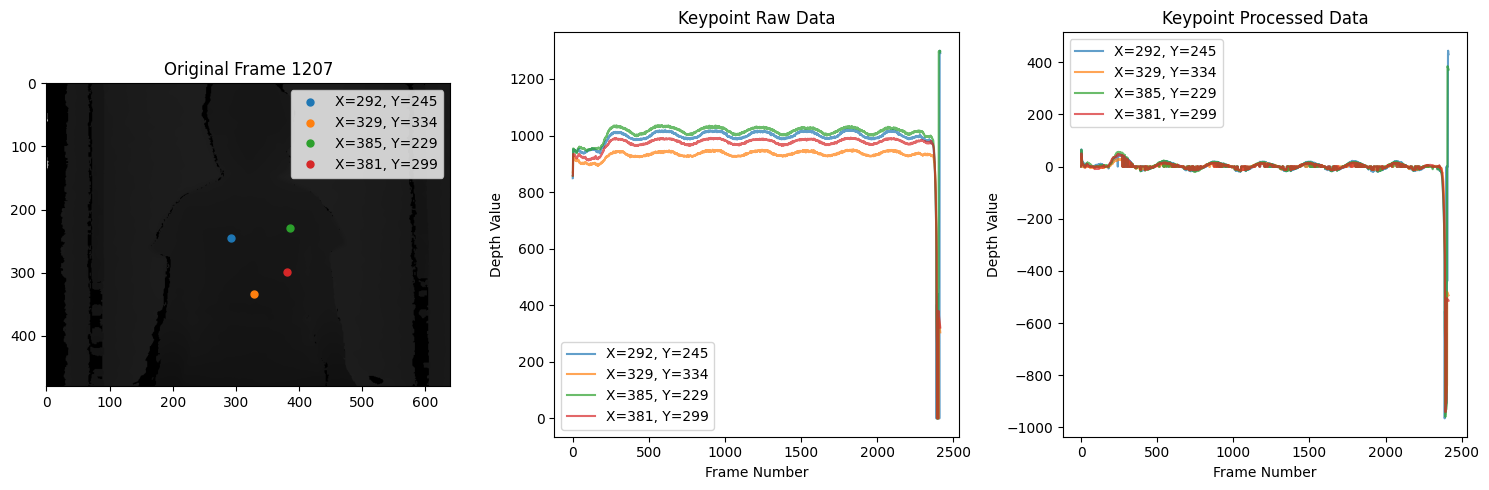

In [ ]:
# Define keypoints and process depth files

folder = "C:/Users/LMAPA/Documents/GitHub/vision-black-tech/"

key_points = [(292, 245), (329, 334), (385, 229), (381, 299)]
depth_file = "UniMelb Breath Sensing Project/Depth Camera Breathing Datasets/Relaxed Exaggerated Breathing/depthOutput.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


In [ ]:
folder = "C:/Users/LMAPA/Documents/GitHub/vision-black-tech/"

key_points = [(292, 245), (329, 334), (385, 229), (381, 299)]
depth_file = "UniMelb Breath Sensing Project/Depth Camera Breathing Datasets/Relaxed Exaggerated Breathing/depthOutput.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


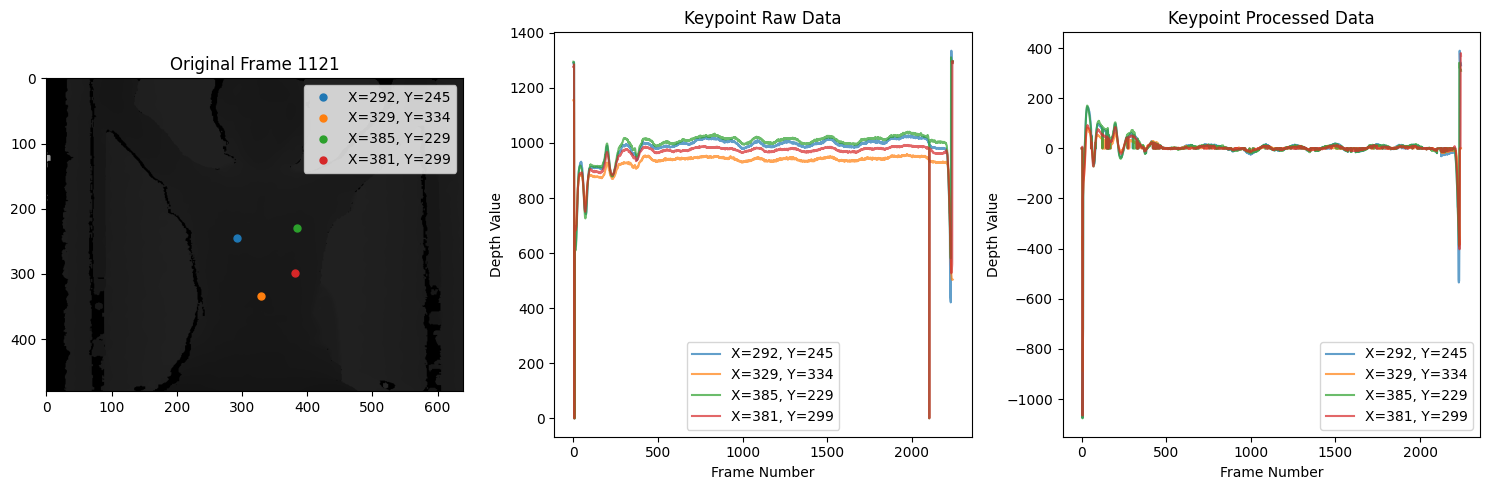

In [47]:
depth_file = "UniMelb Breath Sensing Project/Depth Camera Breathing Datasets/Fidgeting Tidal Breathing/depthOutput.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


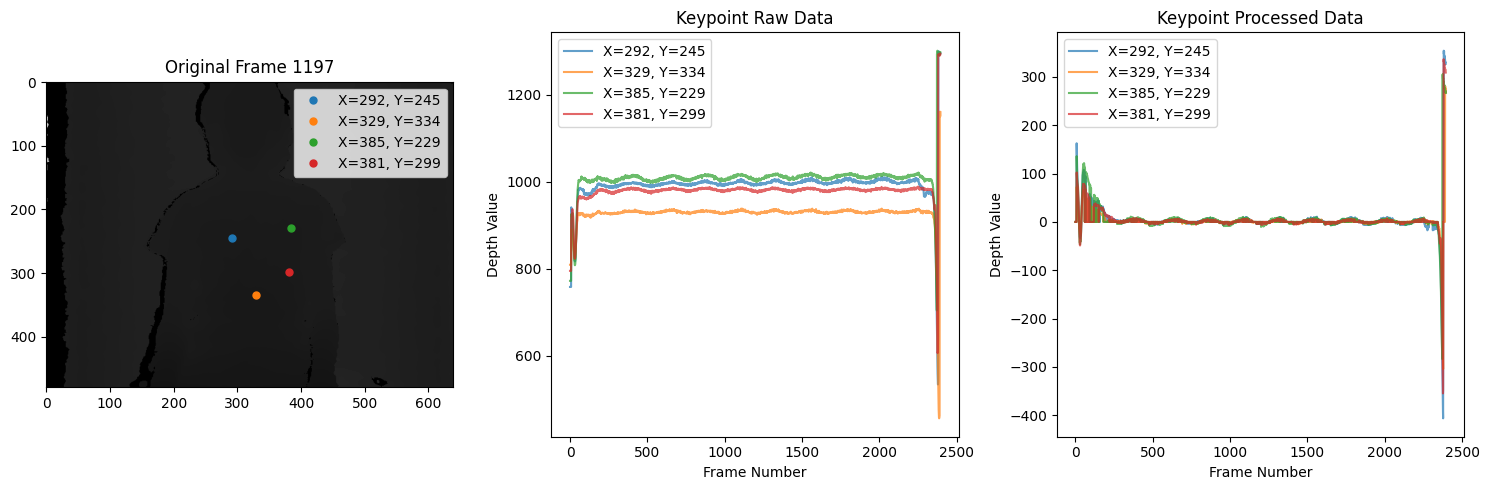

In [48]:
depth_file = "UniMelb Breath Sensing Project/Depth Camera Breathing Datasets/Control - Relaxed Tidal Breathing/depthOutput.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


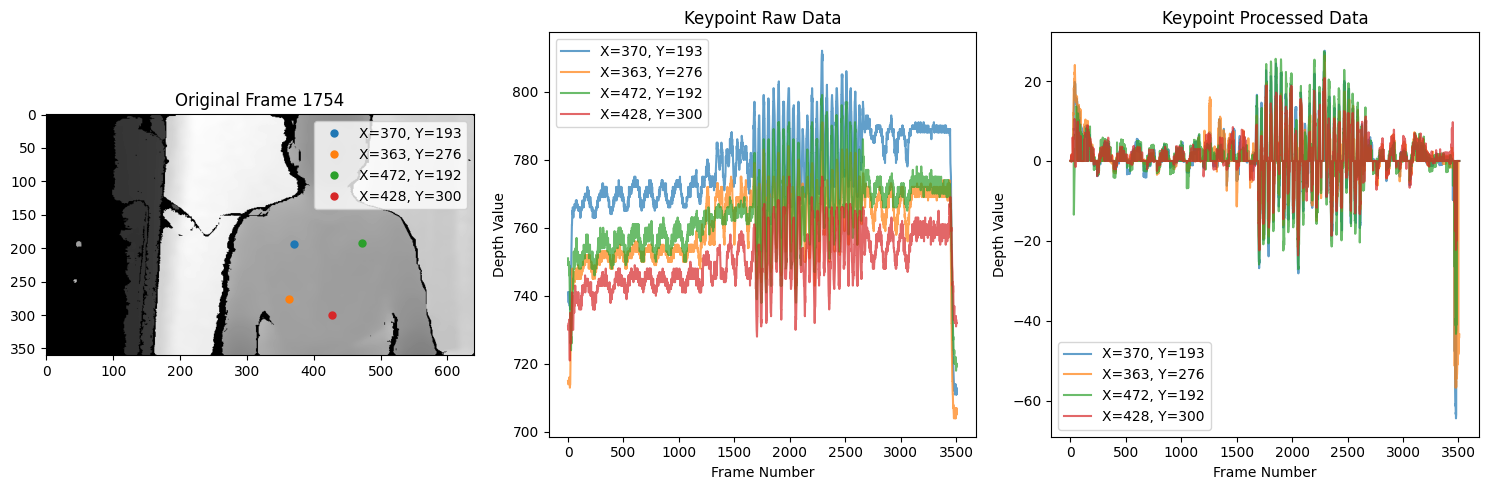

In [49]:
key_points = [(370, 193), (363, 276), (472, 192), (428, 300)]
depth_file = "rs_data/20250319_111903_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


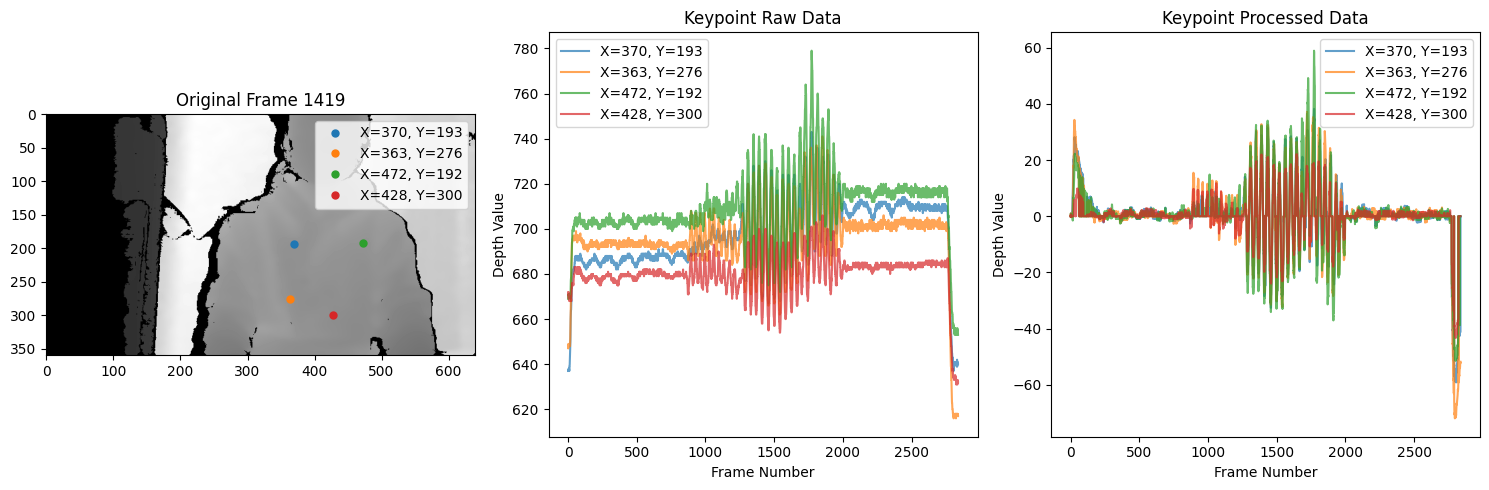

In [50]:
depth_file = "rs_data/20250319_112130_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)


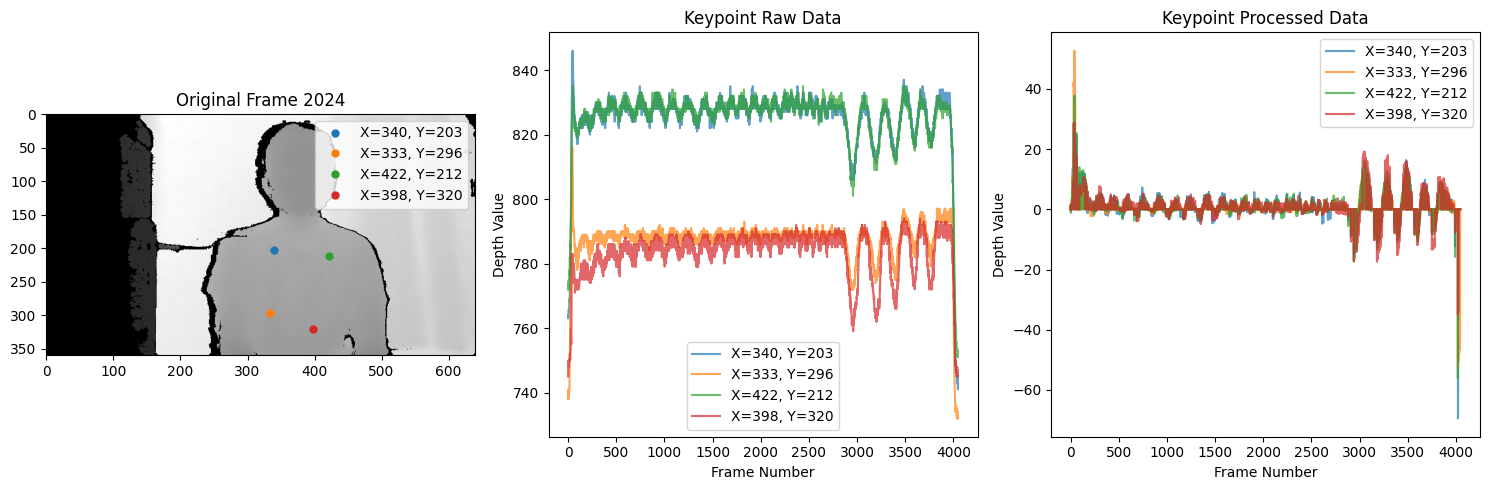

In [60]:
key_points = [(340, 203), (333, 296), (422, 212), (398, 320)]
depth_file = "rs_data/20250320_150946_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
# plot_depth_map(data_loader, key_points)
process_depth_frames(data_loader, key_points)


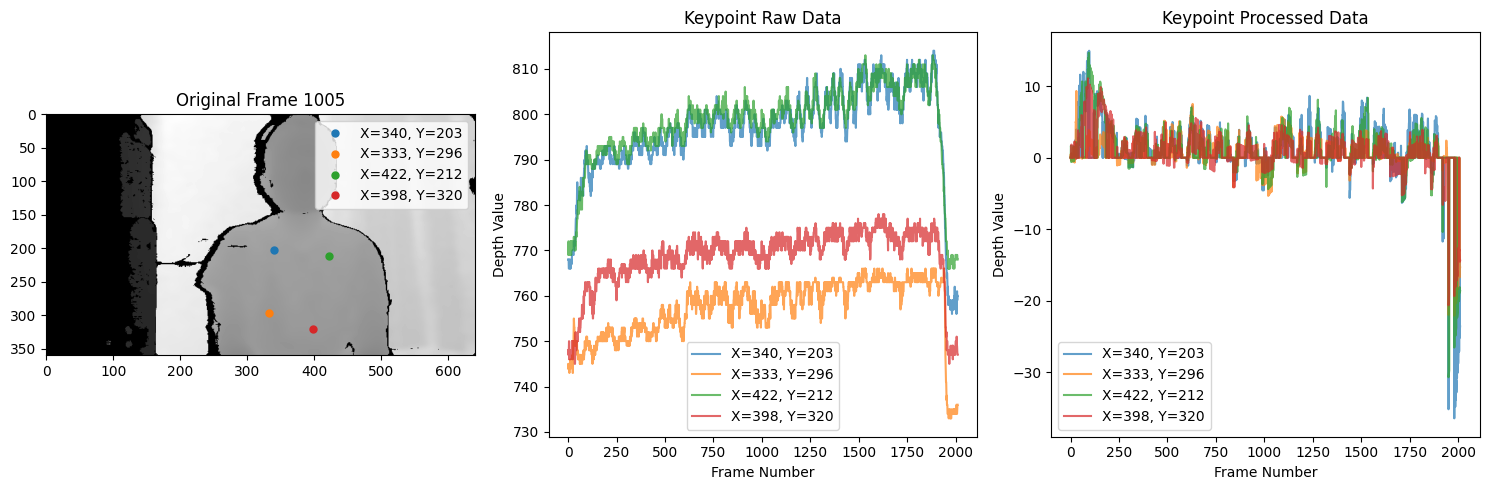

In [61]:
depth_file = "rs_data/20250320_151150_depth_frames.tiff"
data_loader = TiffReader(folder + depth_file)
process_depth_frames(data_loader, key_points)

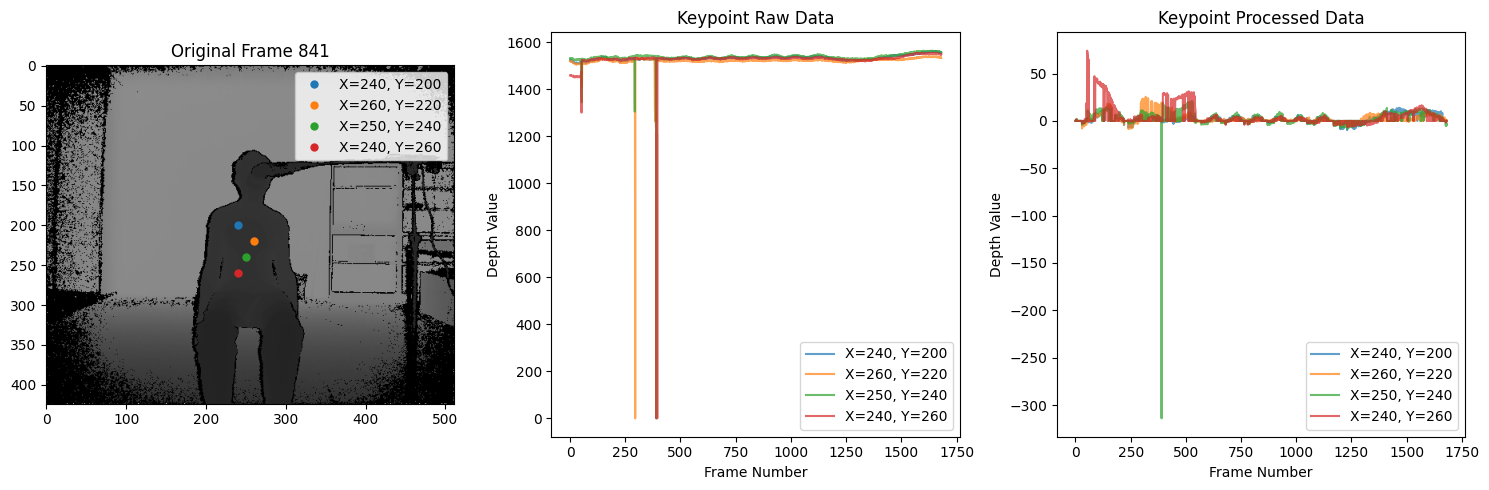

In [53]:
key_points = [(240, 200), (260, 220), (250, 240), (240, 260)]
folder = "D:/1tqzx39mzkw832msuvy3obktqi/subject_10/83/data_fKinect/depth_frames"
data_loader = PngReader(folder)
# plot_depth_map(data_loader, key_points)
process_depth_frames(data_loader, key_points)

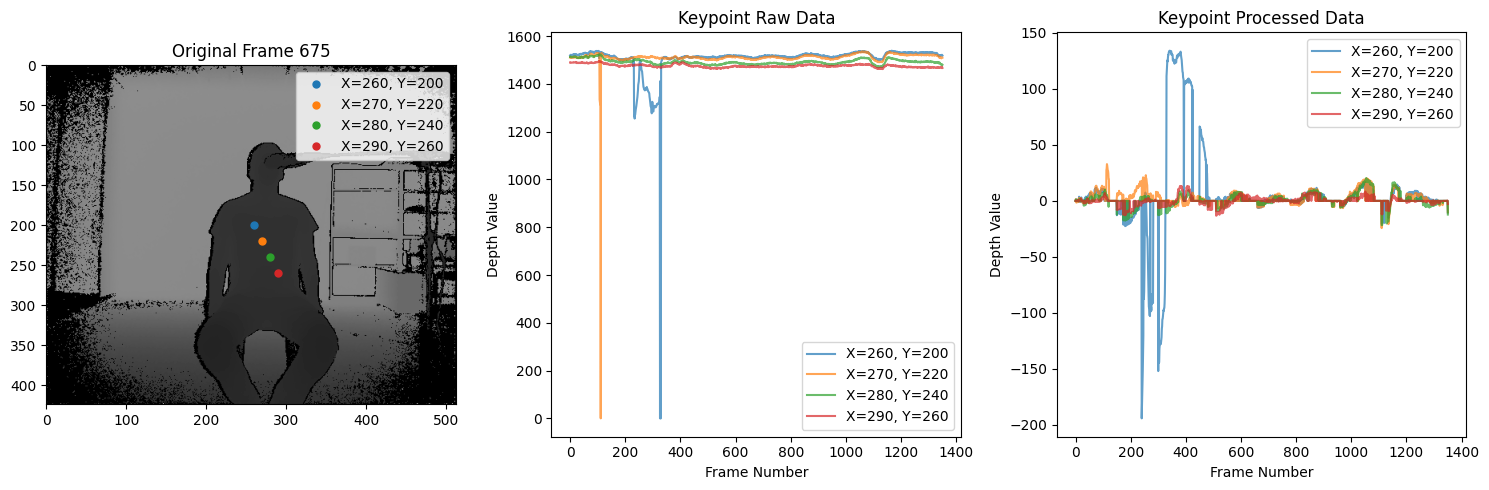

In [54]:
key_points = [(260, 200), (270, 220), (280, 240), (290, 260)]
folder = "D:/1tqzx39mzkw832msuvy3obktqi/subject_26/228/data_fKinect/depth_frames"
data_loader = PngReader(folder)
# plot_depth_map(data_loader, key_points)
process_depth_frames(data_loader, key_points)